# Mental Health in the Tech Industry

Managing mental health is an important part of maintaining productivity at work and having a high-quality life overall. Using data from surveys conducted by Open Sourcing Mental Illness, we can take a deeper dive into how mental health is discussed and managed in the tech industry.

### Setup and Retrieving the Data from SQLite

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
import pandas as pd
import sqlite3

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("mental_health.sqlite")
answers = pd.read_sql_query("SELECT * from Answer", con)
questions = pd.read_sql_query("SELECT * from Question", con)
survey = pd.read_sql_query("SELECT * from Survey", con)

con.close()

In [ ]:


survey_combined = _deepnote_execute_sql("""SELECT questiontext, AnswerText, SurveyID as "YEAR", UserID
FROM answers INNER JOIN questions ON answers.questionID == questions.questionid
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
survey_combined

,questiontext,AnswerText,YEAR,UserID
0,What is your age?,37,2014,1
1,What is your age?,44,2014,2
2,What is your age?,32,2014,3
3,What is your age?,31,2014,4
4,What is your age?,31,2014,5
...,...,...,...,...
236893,Which of the following best describes your wor...,Other,2016,2689
236894,Which of the following best describes your wor...,Support,2016,2690
236895,Which of the following best describes your wor...,Back-end Developer,2016,2691
236896,Which of the following best describes your wor...,DevOps/SysAdmin,2016,2692


In [ ]:


year_counts = _deepnote_execute_sql("""SELECT YEAR, COUNT(DISTINCT UserID) AS NUM_RESPONDENTS, COUNT(DISTINCT questiontext) as NUM_QUESTIONS
FROM survey_combined GROUP BY YEAR
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
year_counts

,YEAR,num_respondents,num_questions
0,2014,1260,26
1,2016,1433,60
2,2017,756,76
3,2018,417,76
4,2019,352,76


In [ ]:


survey_combined = _deepnote_execute_sql("""SELECT YEAR, UserID, questiontext, STRING_AGG(AnswerText, ', ') as Answer
FROM survey_combined GROUP BY YEAR, UserID, questiontext
""", 'SQL_DEEPNOTE_DATAFRAME_SQL')
survey_combined

,YEAR,UserID,questiontext,answer
0,2014,1,What is your age?,37
1,2014,2,What is your age?,44
2,2014,3,What is your age?,32
3,2014,4,What is your age?,31
4,2014,5,What is your age?,31
...,...,...,...,...
234635,2016,2572,Which of the following best describes your wor...,"Supervisor/Team Lead, DevOps/SysAdmin, Back-en..."
234636,2016,2632,Which of the following best describes your wor...,Back-end Developer
234637,2016,2655,Which of the following best describes your wor...,DevOps/SysAdmin
234638,2016,2669,Which of the following best describes your wor...,One-person shop


In [ ]:
dfs = []
for year in [2016, 2017, 2018, 2019]:
    user_ids = survey_combined[survey_combined["YEAR"] == year]["UserID"].unique()
    answers_dict = dict()
    for user in user_ids:
        specific_questions = survey_combined[(survey_combined["YEAR"] == year) & (survey_combined["UserID"] == user)]
        for _, row in specific_questions.iterrows():
            question = row["questiontext"]
            answer = row["answer"]
            if question in answers_dict:
                answers_dict[question].append(answer)
            else:
                answers_dict[question] = [answer]
    new_df = pd.DataFrame.from_dict(answers_dict)
    new_df["Year"] = year
    dfs.append(new_df)        

In [ ]:
common_columns = list(set.intersection(*[set(df.columns) for df in dfs]))
print(len(common_columns))
print(common_columns)
for i in range(len(dfs)):
    dfs[i] = dfs[i][common_columns]


44
['Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?', 'Have you ever been diagnosed with a mental health disorder?', 'Year', 'If you live in the United States, which state or territory do you live in?', 'Did your previous employers provide resources to learn more about mental health disorders and how to seek help?', 'How willing would you be to share with friends and family that you have a mental illness?', 'Have you ever sought treatment for a mental health disorder from a mental health professional?', 'If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?', 'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?', 'Do you have medical coverage (private 

In [ ]:
full_data = pd.concat(dfs, axis=0)

### Data Preprocessing

Nearly all of the data provided is in string form, making it useful for plotting so we can see the values, but difficult for machine learning because of the long values. Additionally, the column names are very long and hard to work with.

In [ ]:
new_column_names = {
    "What country do you live in?": "country_live", "What country do you work in?": "country_work", 
    "How many employees does your company or organization have?": "num_employees", "Are you self-employed?": "is_self_employed", 
    "Does your employer provide mental health benefits as part of healthcare coverage?": "employer_healthcare_coverage",
    "Have you ever sought treatment for a mental health disorder from a mental health professional?": "sought_treatment",
    "What is your age?": "age", "Would you bring up a mental health issue with a potential employer in an interview?": "mental_interview",
    "Is your employer primarily a tech company/organization?": "tech_org", "Year": "year", 
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?": "anonymity_protected",
    "What is your gender?": "gender", "Do you have a family history of mental illness?": "family_history", 
    "If you live in the United States, which state or territory do you live in?": "state_live",
    "What US state or territory do you work in?": "state_work",
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?': "bad_response",
    "Does your employer offer resources to learn more about mental health disorders and options for seeking help?": "employer_resources",
    "Do you know the options for mental health care available under your employer-provided health coverage?": "know_healthcare_options",
    "If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)?": "disorder_interference_symptoms",
    "Do you currently have a mental health disorder?": "has_disorder",
    "Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?": "anonymity_protected_previous",
    'Would you feel comfortable discussing a mental health issue with your coworkers?': "discuss_coworkers",
    'Do you know local or online resources to seek help for a mental health issue?': "knows_resources",
    "Have your previous employers provided mental health benefits?": "mental_benefits_previous",
    "Is your primary role within your company related to tech/IT?": "tech_role",
    "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?": "reveals_treatment_clients",
    "Did your previous employers provide resources to learn more about mental health disorders and how to seek help?": "employer_resources_previous",
    "Do you have previous employers?": "previous_employers",
    "Would you have been willing to discuss your mental health with your direct supervisor(s)?": "discuss_supervisors_previous",
    "If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?": "health_leave_difficulty",
    "If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?": "work_time_percent_affected",
    "Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?": "has_mental_healthcare_coverage",
    "If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?": "reveals_treatment_employees",
    "How willing would you be to share with friends and family that you have a mental illness?": "willing_share_friends_family",
    "Have you had a mental health disorder in the past?": "past_disorder",
    "Have you ever been diagnosed with a mental health disorder?": "past_diagnosis",
    "If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively?": "disorder_interference_treated",
    "Were you aware of the options for mental health care provided by your previous employers?": "aware_employer_options_previous",
    "Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?": "employer_formal_discussion_previous",
    "Do you believe your productivity is ever affected by a mental health issue?": "productivity_affected",
    "Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?": "employer_formal_discussion",
    "Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?": "observations_made_less_likely_to_reveal",
    "Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?": "discuss_supervisors",
    "Would you be willing to bring up a physical health issue with a potential employer in an interview?": "physical_interview"
}

In [ ]:
full_data = full_data.rename(new_column_names, axis=1)

In [ ]:
full_data = full_data.replace("-1", np.nan)
missing = full_data[full_data.isna().sum(axis=1) >= 0.5 * len(full_data.columns)].index
full_data.drop(missing, axis=0, inplace=True)
full_data = full_data.replace(np.nan, "-1")

In [ ]:
# Used this to determine what columns were suited to be binary vs ordinal
# for col in full_data.columns:
#     print(col, full_data[col].unique())

In [ ]:
# for the sake of narrowing the scope, we focus on current employers only
full_data.drop([col for col in full_data.columns if "previous" in col], axis=1, inplace=True)

In [ ]:
# saving a copy of this for plotting while we continue to process the data
full_data_to_plot = full_data.copy()

In [ ]:
yes_no_cols = ["observations_made_less_likely_to_reveal", "employer_resources", "know_healthcare_options", "anonymity_protected",
"discuss_coworkers", "knows_resources", "tech_role", "family_history", "has_mental_healthcare_coverage", "sought_treatment", 
"is_self_employed", "past_diagnosis", "discuss_supervisors", "mental_interview", "employer_formal_discussion", "physical_interview", "tech_org",
"has_disorder", "employer_healthcare_coverage", "past_disorder", "productivity_affected"]
# I am making the choice to indicate the presence of something and have anything indicating no/uncertainty grouped into one category
def convert_yes_no(answer): 
    if type(answer) == int:
        return answer
    if answer.lower() == "yes" or answer == "1":
        return 1
    else:
        return 0

for col in yes_no_cols:
    full_data[col] = full_data[col].apply(convert_yes_no)
    full_data_to_plot[col] = full_data_to_plot[col].apply(convert_yes_no)

In [ ]:
numerical_columns = ['year', 'age']
full_data_to_plot.dropna()
for col in numerical_columns:
    full_data[col] = full_data[col].replace({'-1': 0}).astype(int)
    full_data_to_plot[col] = full_data_to_plot[col].replace({np.nan: 0}).astype(int)

full_data = full_data[full_data["age"] >= 18]
full_data_to_plot = full_data_to_plot[full_data_to_plot["age"] >= 18]


In [ ]:
ordinal_replace = {
    "bad_response": {
        "No": 0,
        "Yes, I experienced": 3,
        "Yes, I observed": 2,
        "Maybe/Not sure": 1,
        "-1": 1,
        "I've always been self-employed": 0
    },
    "disorder_interference_symptoms": {
        "Often": 3,
        "Sometimes": 2,
        "Rarely": 1,
        "Never": 0,
        "Not applicable to me": 0
    },
    "disorder_interference_treated": {
        "Often": 3,
        "Sometimes": 2,
        "Rarely": 1,
        "Never": 0,
        "Not applicable to me": 0
    },
    "health_leave_difficulty": {
        "Very difficult": 3,
        "Difficult": 2,
        "Somewhat difficult": 1,
        "Neither easy nor difficult": 0,
        "Somewhat easy": -1,
        "Very easy": -2,
        "I don't know": 0,
        "-1": 0
    },
    "num_employees": {
        '-1': 0,
        '1-5': 1,
        '6-25': 2,
        '26-100': 3,
        '100-500': 4,
        '500-1000': 5,
        'More than 1000': 6
    },
    "reveals_treatment_clients": {
        'No, because it would impact me negatively': -2,
        "No, because it doesn't matter": -1,
        'Not applicable to me': 0,
        '-1': 0,
        'Sometimes, if it comes up': 1,
        'Yes, always': 2
    },
    "reveals_treatment_employees": {
        'No, because it would impact me negatively': -2,
        "No, because it doesn't matter": -1,
        'Not applicable to me': 0,
        '-1': 0,
        'Sometimes, if it comes up': 1,
        'Yes, always': 2
    },
    "willing_share_friends_family": {
        'Not open at all': -1,
        'Somewhat not open': -1,
        'Neutral': 0,
        'Not applicable to me (I do not have a mental illness)':0,
        'Somewhat open': 1,
        'Very open': 1,
    },
    "work_time_percent_affected": {
        "-1": 0,
        "1-25%": 1, 
        '26-50%': 2, 
        '51-75%': 3,
        '76-100%': 4
    }
}

In [ ]:
full_data.replace(ordinal_replace, inplace=True)
full_data_to_plot.replace(ordinal_replace, inplace=True)
full_data

,anonymity_protected,past_diagnosis,year,state_live,willing_share_friends_family,sought_treatment,disorder_interference_symptoms,observations_made_less_likely_to_reveal,has_mental_healthcare_coverage,knows_resources,...,num_employees,has_disorder,reveals_treatment_employees,disorder_interference_treated,employer_healthcare_coverage,past_disorder,tech_org,employer_formal_discussion,productivity_affected,family_history
0,0,1,2016,-1,0,1,2,0,1,0,...,0,1,1,2,0,1,0,0,1,0
1,0,1,2016,Illinois,1,1,2,1,0,0,...,2,1,0,2,1,1,0,0,0,1
2,1,0,2016,-1,1,1,3,0,0,0,...,6,1,0,0,1,0,1,0,0,0
3,1,1,2016,Virginia,1,1,3,0,0,0,...,6,1,0,2,1,1,1,0,0,1
4,0,1,2016,-1,1,0,0,0,0,0,...,3,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,1,2019,Texas,1,1,3,1,0,0,...,4,1,0,3,1,1,1,0,0,1
348,0,0,2019,Maryland,1,1,2,0,0,0,...,6,0,0,2,1,1,0,0,0,1
349,0,0,2019,-1,1,1,3,0,0,0,...,6,0,0,1,1,1,0,1,0,0
350,0,0,2019,California,1,1,0,0,0,0,...,4,0,0,0,0,0,1,0,0,0


In [ ]:
def categorize_genders(gender):
    if gender.lower() == "male":
        return "cis_male"
    elif gender.lower() == "female":
        return "cis_female"
    else:
        return "trans_nb_other"

full_data["gender"] = full_data["gender"].apply(categorize_genders)
full_data_to_plot["gender"] = full_data_to_plot["gender"].fillna("-1").apply(categorize_genders)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encode_columns = ["country_live", "country_work", "state_live", "state_work", "gender"]
for col in encode_columns:
    encoder = LabelEncoder()
    encoder.fit(full_data[col])
    full_data[col] = encoder.transform(full_data[col])
full_data_to_plot.replace({"-1": "N/A"}, inplace=True)

In [ ]:
full_data.to_csv("full_data.csv", index=None)
full_data_to_plot.to_csv("full_data_plot.csv", index=None)

### Visualization: How are companies doing when it comes to supporting their employees' mental health? What about when we focus on tech companies and tech roles?

In [ ]:
column_to_question_name = dict([(value, key) for key, value in new_column_names.items()])

In [ ]:
fig = px.histogram(full_data_to_plot, x="age", y="sought_treatment",
             color='gender', barmode='group', height=400, histfunc="avg",
             title="Rate of Individuals who Seek Mental Health Treatment by Age and Gender",
             labels = {"sought_treatment": "people who sought treatment"})
fig.show()

In [ ]:
tech_treatment_var = 'bad_response'

In [ ]:
print(f"Question for variable {tech_treatment_var}: ", column_to_question_name[tech_treatment_var])

fig1 = px.histogram(full_data_to_plot, x="tech_org", y=tech_treatment_var,
             color=tech_treatment_var, barmode='group', height=400, histfunc="count", 
             title="Comparison of Mental Health Treatment at Tech Companies vs. Other Companies")

if tech_treatment_var in yes_no_cols:
    value_labels = {'1': "Yes", '0': "No"}
else: 
    value_labels = dict([(str(value), key) if key != "-1" else (str(value), "No Answer") for key, value in ordinal_replace[tech_treatment_var].items()])
   
fig1.for_each_trace(lambda t: t.update(name = value_labels[t.name],
                                      legendgroup = value_labels[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, value_labels[t.name])
                                    ))
fig1.update_layout(xaxis = dict(tickmode = 'array', tickvals = [0, 1], ticktext = ["No", "Yes"]))
fig1.show()


fig2 = px.histogram(full_data_to_plot, x="tech_org", y="sought_treatment",
             color=tech_treatment_var, barmode='group', height=400, histfunc="avg", 
             title="Effect of Companies' Attitudes towards Mental Health on Seeking Treatment")
fig2.for_each_trace(lambda t: t.update(name = value_labels[t.name],
                                      legendgroup = value_labels[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, value_labels[t.name])
                                    )) 
fig2.update_layout(xaxis = dict(tickmode = 'array', tickvals = [0, 1], ticktext = ["No", "Yes"]))
fig2.show()

data_copy = full_data_to_plot.copy()
data_copy["tech_org"] = data_copy["tech_org"].astype(str)
fig3 = px.scatter(data_copy, x="country_work", y=tech_treatment_var, color="tech_org", 
symbol="tech_org", title="Company Attitude towards Mental Health by Country")
fig3.update_yaxes(type='category')
fig3.update_layout(
    yaxis = dict(
        tickmode = 'array',
        tickvals = sorted(full_data_to_plot[tech_treatment_var].unique()),
        ticktext = [value_labels[str(val)] for val in sorted(full_data_to_plot[tech_treatment_var].unique())]
    )
)
fig3.for_each_trace(lambda t: t.update(name = "Yes" if t.name == '1' else "No",
                                      legendgroup = "Yes" if t.name == '1' else "No",
                                      hovertemplate = t.hovertemplate.replace(t.name, "Yes" if t.name == '1' else "No")
                                    )) 
fig3.show()

Question for variable bad_response:  Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?


In [ ]:
grouped = full_data_to_plot.groupby(["year", "tech_org"]).mean()["sought_treatment"].reset_index()
fig = px.line(grouped, x="year", y="sought_treatment", color='tech_org', title="Change in Rate of Treatment Sought Over Time")
fig.update_xaxes(type='category')
fig.for_each_trace(lambda t: t.update(name = "Yes" if t.name == '1' else "No",
                                      legendgroup = "Yes" if t.name == '1' else "No",
                                      hovertemplate = t.hovertemplate.replace(t.name, "Yes" if t.name == '1' else "No")
                                    )) 
fig.show()

Overall, tech companies seem to provide some mental health accommodations and somewhat facilitate an environment where people feel comfortable to talk about mental health. There is also an upward trend in tech over time for those seeking treatment for their mental health, while there is a downward trend for non-tech companies. This is kind of a mix of good and bad. 

### Prediction: What are the strongest indicators of employees who seek mental health treatment? Does it have anything to do with the companies where they work?

In [ ]:
_deepnote_run_altair(full_data, """{"$schema":"https://vega.github.io/schema/vega-lite/v4.json","mark":{"type":"bar","tooltip":{"content":"data"}},"height":220,"autosize":{"type":"fit"},"data":{"name":"placeholder"},"encoding":{"x":{"field":"sought_treatment","type":"ordinal","sort":null,"scale":{"type":"linear","zero":false}},"y":{"field":"COUNT(*)","type":"quantitative","sort":null,"aggregate":"count","scale":{"type":"linear","zero":true}},"color":{"field":"","type":"nominal","sort":null,"scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

<AxesSubplot:>

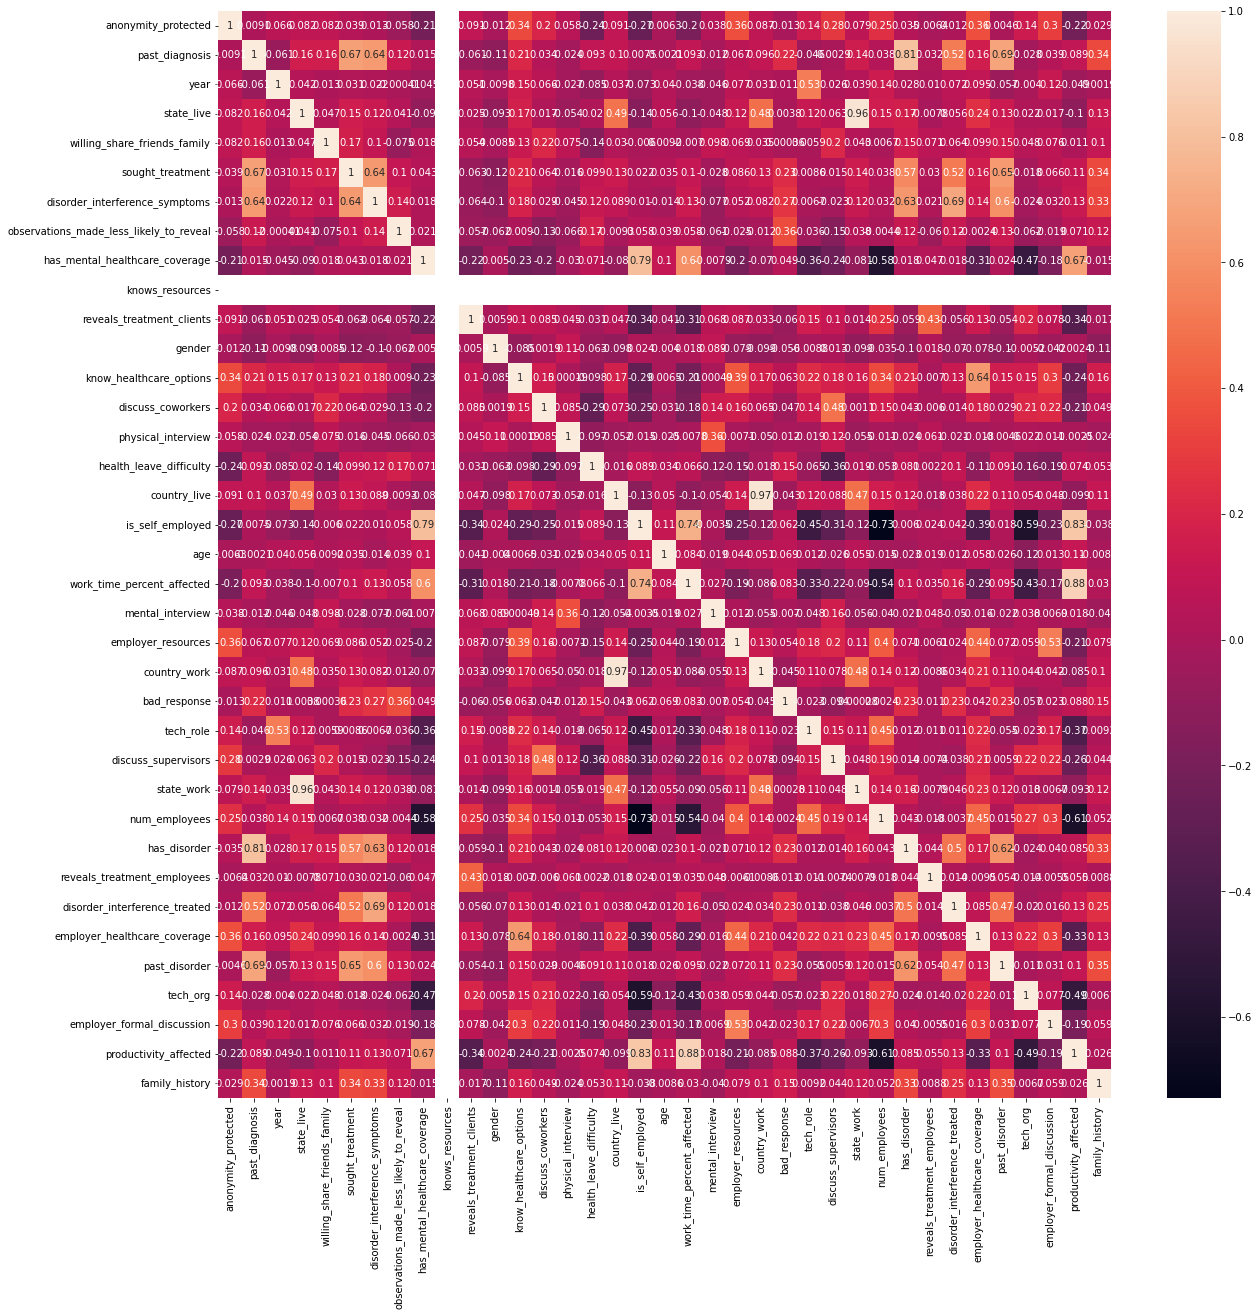

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(full_data.corr(), annot=True)

In [ ]:
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X = full_data.drop(["sought_treatment", "past_diagnosis", "past_disorder", "disorder_interference_symptoms", "disorder_interference_treated", "has_disorder"], axis=1)
y = full_data["sought_treatment"]
Xtrain, Xother, ytrain, yother = train_test_split(X, y, test_size=0.4, random_state=0)
Xval, Xtest, yval, ytest = train_test_split(Xother, yother, test_size=0.5, random_state=0)

In [ ]:
# If we guessed the majority label for everything, how accurate would we be?
# This is a sanity baseline
y.mean()

0.6

First: A baseline model to get some general insights about predictors

In [ ]:
baseline_model = LogisticRegression()
baseline_model.fit(Xtrain, ytrain)
valpreds = baseline_model.predict(Xval)
print(classification_report(yval, valpreds))

              precision    recall  f1-score   support

           0       0.66      0.53      0.59       236
           1       0.72      0.82      0.77       352

    accuracy                           0.70       588
   macro avg       0.69      0.68      0.68       588
weighted avg       0.70      0.70      0.70       588

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Looking at the feature importances of this baseline model, it seems like the strong predictors are whether the individual has family history, whether they observed or experienced a bad response to discussing mental health at work, whether they're willing to share their mental health with friends and family, whether they know their healthcare options, and the amount of work time that is affected by their mental health. 

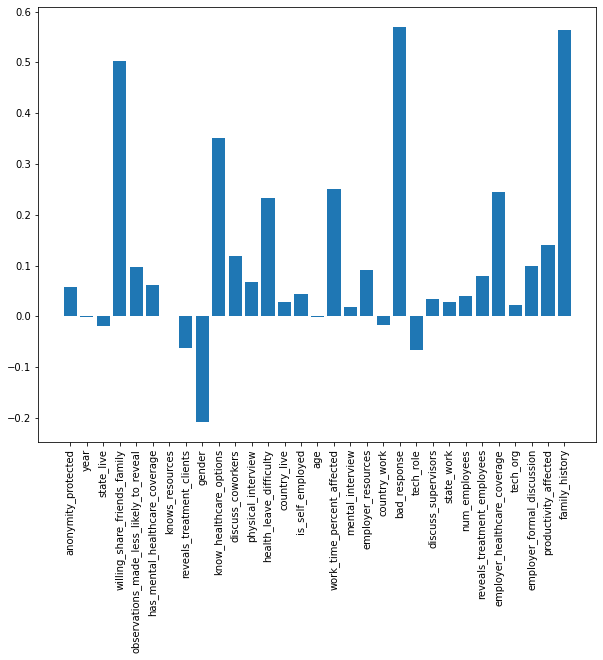

In [ ]:
feat_importance = baseline_model.coef_[0]
plt.figure(figsize=(10, 8))
plt.bar(X.columns, feat_importance)
plt.xticks(rotation=90)
plt.show()

In [ ]:
model = CatBoostClassifier(iterations=500,
                           max_depth=8,
                           learning_rate=0.05)
model.fit(X, y)

0:	learn: 0.6765977	total: 5.28ms	remaining: 2.63s
1:	learn: 0.6601899	total: 9.81ms	remaining: 2.44s
2:	learn: 0.6486692	total: 11.5ms	remaining: 1.9s
3:	learn: 0.6344674	total: 16.3ms	remaining: 2.02s
4:	learn: 0.6247616	total: 21.1ms	remaining: 2.09s
5:	learn: 0.6163594	total: 25.8ms	remaining: 2.12s
6:	learn: 0.6057340	total: 30.8ms	remaining: 2.17s
7:	learn: 0.5978302	total: 35.8ms	remaining: 2.2s
8:	learn: 0.5890035	total: 40.7ms	remaining: 2.22s
9:	learn: 0.5835178	total: 45.7ms	remaining: 2.24s
10:	learn: 0.5768818	total: 50.6ms	remaining: 2.25s
11:	learn: 0.5705854	total: 55.7ms	remaining: 2.26s
12:	learn: 0.5642805	total: 60.6ms	remaining: 2.27s
13:	learn: 0.5580300	total: 65.8ms	remaining: 2.28s
14:	learn: 0.5526169	total: 70.6ms	remaining: 2.28s
15:	learn: 0.5476582	total: 75.6ms	remaining: 2.29s
16:	learn: 0.5421376	total: 80.5ms	remaining: 2.29s
17:	learn: 0.5376439	total: 93.2ms	remaining: 2.5s
18:	learn: 0.5337753	total: 99.2ms	remaining: 2.51s
19:	learn: 0.5303539	tota

In [ ]:
valpreds = model.predict(Xval)
print(classification_report(yval, valpreds))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       236
           1       0.99      0.98      0.98       352

    accuracy                           0.98       588
   macro avg       0.98      0.98      0.98       588
weighted avg       0.98      0.98      0.98       588



After using CatBoost, we can observe that there are more features that have significant contributions to whether someone decides to seek mental health treatment, including their age, the difficulty of taking a health leave, and the size of the company. 

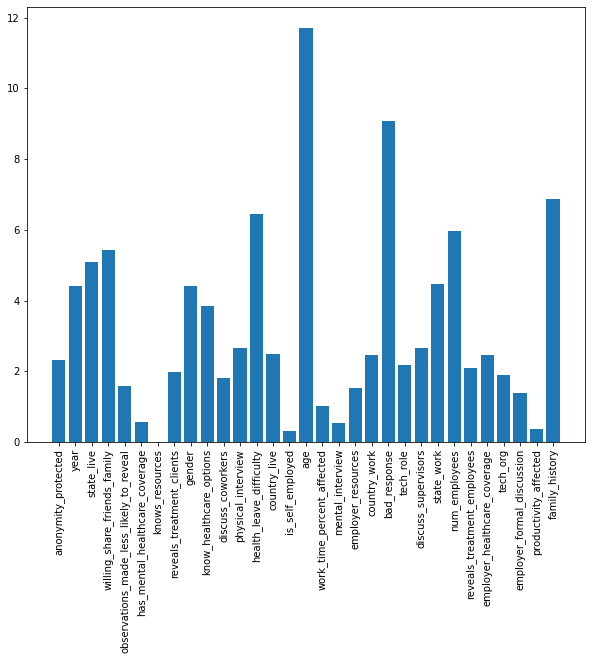

In [ ]:
feature_importances = model.get_feature_importance(type="FeatureImportance")
plt.figure(figsize=(10, 8))
plt.bar(X.columns, feature_importances)
plt.xticks(rotation=90)
plt.show()

In [ ]:
testpreds = model.predict(Xtest)
print(classification_report(ytest, testpreds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       249
           1       0.99      0.98      0.99       339

    accuracy                           0.98       588
   macro avg       0.98      0.98      0.98       588
weighted avg       0.98      0.98      0.98       588



With further analysis into this data, expanding on more aspects of the data, and using more recent data, this kind of work can have massive implications on how companies handle their health policies to ensure that their employees are taking care of their mental health as much as their physical health.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fd8ecb37-4a77-4daf-8e76-ee6f1594da4b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>